**Importing required libraries**# 

In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
from scipy.stats import pearsonr
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
print('ALL okay') #confirmation check

ALL okay


**Loading dataset**

In [2]:
'''
NOTE: All the dataset are uploaded in notebook section privately
Before using, please check for mentioning path
'''
# Correct file paths for the Kaggle environment
train_file_path = "C:/Users/kg316/Downloads/gq-implied-volatility-forecasting/ETH_train.csv" 
test_file_path = "C:/Users/kg316/Downloads/gq-implied-volatility-forecasting/ETH_test.csv" 

# other asset data for cross-asset features 
other_asset_train_path ="C:/Users/kg316/Downloads/gq-implied-volatility-forecasting/BTC_train.csv" 
other_asset_test_path = "C:/Users/kg316/Downloads/gq-implied-volatility-forecasting/BTC_test.csv" 

# Load the data
other_asset_df_train = pd.read_csv(other_asset_train_path)
other_asset_df_test = pd.read_csv(other_asset_test_path)
df_train = pd.read_csv(train_file_path)
df_test = pd.read_csv(test_file_path)
# df_train_btc = pd.read_csv(btc_train_path)
# df_test_btc = pd.read_csv(btc_test_path)

# --- Configuration ---
timestamp_column = 'timestamp'
mid_price_column = 'mid_price'
label_column = 'label'
print('This block is okay') #confirmation check

This block is okay


**Feature Engineering**

In [3]:
def engineer_features(df, other_asset_df=None):
    """
    Engineers the requested features on a DataFrame.
    """
    print("Performing feature engineering...")

    # Corrected timestamp conversion and index setting
    df[timestamp_column] = pd.to_datetime(df[timestamp_column])
    df.set_index(timestamp_column, inplace=True)
    
    # Handling missing values (filling them)
    df.fillna(method='ffill', inplace=True)
    df.dropna(inplace=True)
    
    # Rolling Realized Volatility over a 60-second window
    log_returns = np.log(df[mid_price_column] / df[mid_price_column].shift(1))
    df['realized_volatility_60s'] = log_returns.rolling('60s').std() * np.sqrt(365 * 24 * 60*60 )
    df['realized_volatility_10s'] = log_returns.rolling('10s').std() * np.sqrt(365 * 24 * 60*60 )
    
    # Calculating ask-bid spread 
    df['spread1'] = df['ask_price1'] - df['bid_price1'].shift(10) 
    # df['spread2'] = df['ask_price2'] - df['bid_price2'].shift(10) 
    df['spread3'] = df['ask_price3'] - df['bid_price3'].shift(10)  
    # df['spread4'] = df['ask_price4'] - df['bid_price4'].shift(10) 
    # df['spread5'] = df['ask_price5'] - df['bid_price5'].shift(10) 

     # Engineering Weighted Average price
    df['WAP1'] = ((df['ask_price1']* df['bid_volume1'] ) + (df['bid_price1']* df['ask_volume1'] )) / (df['ask_volume1'] + df['bid_volume1']).shift(10) 
    # df['WAP2'] = ((df['ask_price2']* df['bid_volume2'] ) + (df['bid_price2']* df['ask_volume2'] )) / (df['ask_volume2'] + df['bid_volume2']).shift(10)  
    # df['WAP3'] = ((df['ask_price3']* df['bid_volume3'] ) + (df['bid_price3']* df['ask_volume3'] )) / (df['ask_volume3'] + df['bid_volume3']).shift(10)  
    # df['WAP4'] = ((df['ask_price4']* df['bid_volume4'] ) + (df['bid_price4']* df['ask_volume4'] )) / (df['ask_volume4'] + df['bid_volume4']).shift(10)  
    df['WAP5'] = ((df['ask_price5']* df['bid_volume5'] ) + (df['bid_price5']* df['ask_volume5'] )) / (df['ask_volume5'] + df['bid_volume5']).shift(10)  
    
    #Averaged Weighted Average price of all 5 level
    # df['AWAP']= df['WAP1'] + df['WAP2']+ df['WAP3']+ df['WAP4']+ df['WAP5'].shift(10) 
    
    # 2. Order-book Imbalance
    df['order_book_imbalance_1'] = (df['bid_volume1'] - df['ask_volume1']) / (df['bid_volume1'] + df['ask_volume1']).shift(10) 
    # df['order_book_imbalance_2'] = (df['bid_volume2'] - df['ask_volume2']) / (df['bid_volume2'] + df['ask_volume2']).shift(10) 
    # df['order_book_imbalance_3'] = (df['bid_volume3'] - df['ask_volume3']) / (df['bid_volume3'] + df['ask_volume3']).shift(10) 
    # df['order_book_imbalance_4'] = (df['bid_volume4'] - df['ask_volume4']) / (df['bid_volume4'] + df['ask_volume4']).shift(10) 
    df['order_book_imbalance_5'] = (df['bid_volume5'] - df['ask_volume5']) / (df['bid_volume5'] + df['ask_volume5']).shift(10) 

    # CReating lagged features (1s, 5s and 10s)
    df['OBI_lagged_1s'] = df['order_book_imbalance_1'].shift(1)
    df['OBI_lagged_5s'] = df['order_book_imbalance_1'].shift(5)
    df['OBI_lagged_10s'] = df['order_book_imbalance_1'].shift(10)
    df['WAP_lagged_1s'] = df['WAP1'].shift(1)
    df['WAP_lagged_5s'] = df['WAP1'].shift(5)
    df['WAP_lagged_10s'] = df['WAP1'].shift(10)
    
    # 3. Cross-Asset Returns
    if other_asset_df is not None:
        other_asset_df[timestamp_column] = pd.to_datetime(other_asset_df[timestamp_column])
        other_asset_df.set_index(timestamp_column, inplace=True)
        other_asset_df.rename(columns={mid_price_column: 'other_asset_mid_price'}, inplace=True)
        df = df.merge(other_asset_df[['other_asset_mid_price']], left_index=True, right_index=True, how='left')
        df.fillna(method='ffill', inplace=True)
        df['other_asset_log_returns'] = np.log(df['other_asset_mid_price'] / df['other_asset_mid_price'].shift(1))
        df['realized_volatility_60s'] = df['other_asset_log_returns'].rolling('60s').std() * np.sqrt(365 * 24 * 60)
        df['lagged_other_asset_Volatility_10s'] = df['realized_volatility_60s'].shift(10)
        df['lagged_other_asset_Volatility_5s'] = df['realized_volatility_60s'].shift(5)
        
    # Dropping NaN value rows after rolling calculation
    df.dropna(inplace=True) 
    
    print("Feature engineering complete.")
    return df

# Apply the feature engineering to both training and test data
df_train = engineer_features(df_train,other_asset_df_train)
df_test = engineer_features(df_test,other_asset_df_test)

Performing feature engineering...


C:\Users\kg316\AppData\Local\Temp\ipykernel_16784\548718907.py:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
C:\Users\kg316\AppData\Local\Temp\ipykernel_16784\548718907.py:54: UserWarning: Parsing dates in %d-%m-%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  other_asset_df[timestamp_column] = pd.to_datetime(other_asset_df[timestamp_column])
C:\Users\kg316\AppData\Local\Temp\ipykernel_16784\548718907.py:58: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


Feature engineering complete.
Performing feature engineering...


C:\Users\kg316\AppData\Local\Temp\ipykernel_16784\548718907.py:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
C:\Users\kg316\AppData\Local\Temp\ipykernel_16784\548718907.py:58: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


Feature engineering complete.


**Feature selection and seperation for cross validation**

In [4]:
# Separate features and target variable for cross validation 
from sklearn.metrics import r2_score
features = [col for col in df_train.columns if col != label_column]
X_train = df_train[features]
y_train = df_train[label_column]
print("Feature and target variables are seperated")

Feature and target variables are seperated


**MODEL TRAINING AND CROSS VALIDATION**  

In [19]:
# --- Model Training and Walk-Forward Validation ---
print("\nStarting walk-forward cross-validation...")

# Define walk-forward validation with 5 splits
n_splits = 7
tscv = TimeSeriesSplit(n_splits=n_splits) # Using TimeSeriesSplit for proper data splitting in cross validation.

# Initialize the LightGBM model
model = lgb.LGBMRegressor(objective='regression',metric = 'rmse', random_state=42, n_estimators=105, learning_rate=0.023, force_row_wise=True)
# model = LinearRegression()
#Ceatig empty lists to store meaningful data from cross validation 
rmse_scores = []
mae_scores = []
r2_scores = []
pearson_scores =[] #Using pearson coefficient for actual IV v/s predicted IV figuring
all_y_val_folds = [] # actual data in test set 
all_val_preds_folds = [] #predicetd data for test set
for train_index, val_index in tscv.split(X_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

    #MODEL FITTING 
    model.fit(X_train_fold, y_train_fold)
    val_preds = model.predict(X_val_fold)
    
    # Storing results for this fold
    all_y_val_folds.append(y_val_fold)
    all_val_preds_folds.append(val_preds)

    r2 = r2_score(y_val_fold, val_preds) # Calculating R-squared score
    fold_pearson, _ = pearsonr(y_val_fold, val_preds) 
    print(f"RMSE:{np.sqrt(mean_squared_error(y_val_fold, val_preds))}")  
    print(f"MAE: {mean_absolute_error(y_val_fold, val_preds)}")
    print(f"R2_SCORE: {r2}")
    print(f"Pearson of this fold :{fold_pearson}")

    #Storing Performance metrics for proper understanding of every fold.
    rmse_scores.append(np.sqrt(mean_squared_error(y_val_fold, val_preds)))
    mae_scores.append(mean_absolute_error(y_val_fold, val_preds))
    r2_scores.append(r2)
    pearson_scores.append(fold_pearson)
    
#DISPLAYING ACTUAL METRICS OVER ALL FOLDS IN CROSS VALIDATION    
print(f"Average Walk-Forward RMSE: {np.mean(rmse_scores):.6f}")
print(f"Average Walk-Forward MAE: {np.mean(mae_scores):.6f}")
print(f"R-squared score for this fold: {r2:.6f}")
print(f"Fold pearson correlation:{np.mean(pearson_scores)}")


Starting walk-forward cross-validation...
[LightGBM] [Info] Total Bins 9945
[LightGBM] [Info] Number of data points in the train set: 156501, number of used features: 39
[LightGBM] [Info] Start training from score 0.000064
RMSE:4.054057944924927e-05
MAE: 3.3833384418318324e-05
R2_SCORE: 0.33045492563961865
Pearson of this fold :0.6835665497958723
[LightGBM] [Info] Total Bins 9945
[LightGBM] [Info] Number of data points in the train set: 312999, number of used features: 39
[LightGBM] [Info] Start training from score 0.000055
RMSE:3.9037276570564186e-05
MAE: 2.9071927335669768e-05
R2_SCORE: 0.38931286420931943
Pearson of this fold :0.6362353588451132
[LightGBM] [Info] Total Bins 9945
[LightGBM] [Info] Number of data points in the train set: 469497, number of used features: 39
[LightGBM] [Info] Start training from score 0.000054
RMSE:3.4916257723798075e-05
MAE: 2.5840262730546154e-05
R2_SCORE: 0.1721843183808579
Pearson of this fold :0.419014122650163
[LightGBM] [Info] Total Bins 9945
[L

**LINE GRAPH: ACTUAL IMPLIED VOLATILITY V/S PREDICTED IMPLIED VOLATILITY**


Generating line graph for a sample of the validation data...


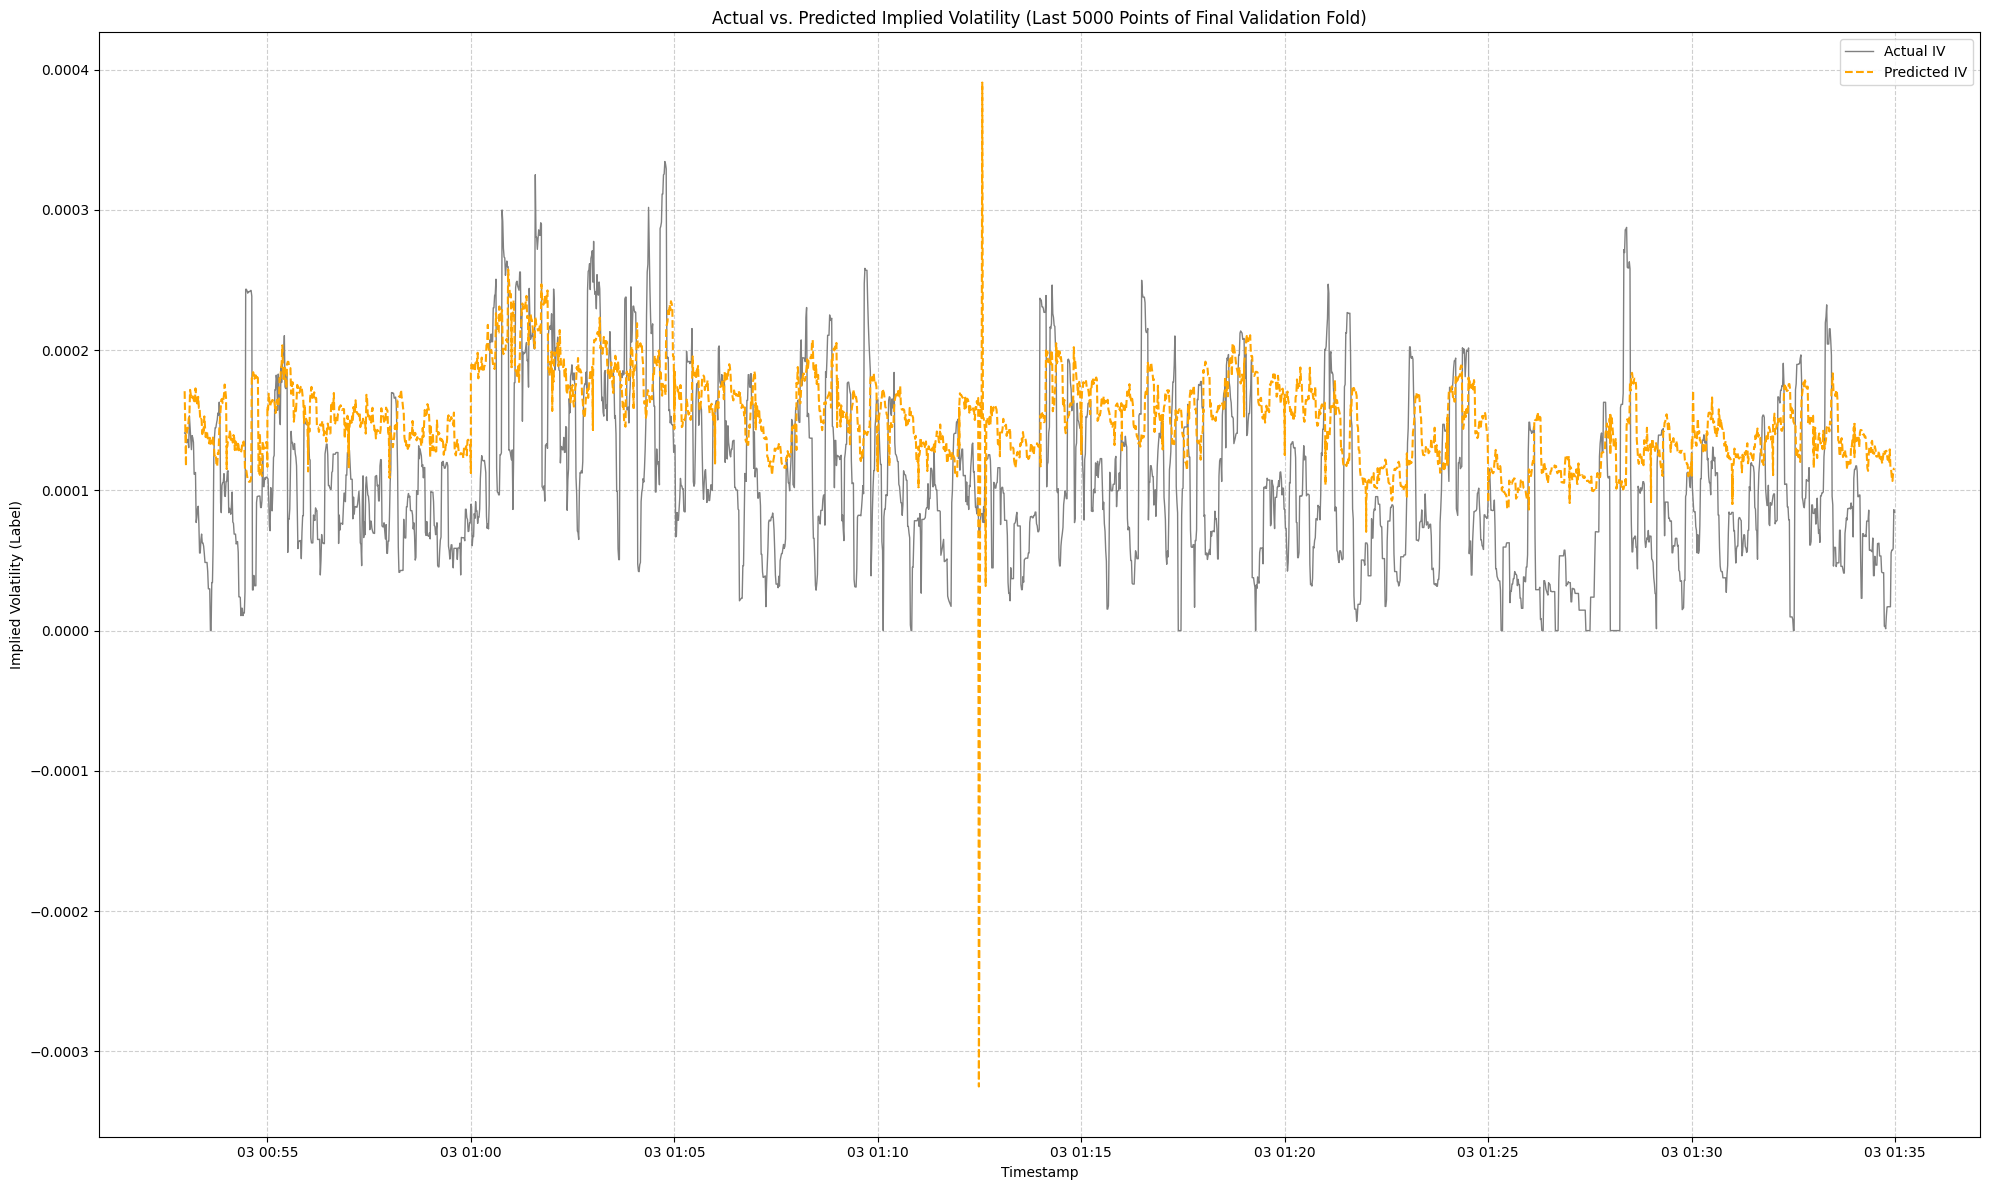

In [6]:
# --- Line Graph: Actual vs. Predicted IV (Last 5000 points of last CV fold) ---
'''
Plotting only on last 5000 rows data since model would be trained better in last fold.
It's best to plot a smaller, continuous segment to see the tracking clearly.
Let's use the actuals and predictions from the final cross-validation fold.
'''

print("\nGenerating line graph for a sample of the validation data...")
last_fold_actuals = all_y_val_folds[-1]
last_fold_preds = pd.Series(all_val_preds_folds[-1], index=last_fold_actuals.index)

# Select the last 5000 data points for a clear plot
points_to_plot = 5000
plot_actuals = last_fold_actuals.tail(points_to_plot)
plot_preds = last_fold_preds.tail(points_to_plot)

# Creating the plot
plt.figure(figsize=(20,12))
plt.plot(plot_actuals.index, plot_actuals, label='Actual IV', color='grey', linewidth=1)
plt.plot(plot_preds.index, plot_preds, label='Predicted IV', color='orange', linestyle='--', linewidth=1.5)

# Declaring plot essential for better clarity
plt.title(f'Actual vs. Predicted Implied Volatility (Last {points_to_plot} Points of Final Validation Fold)')
plt.xlabel('Timestamp')
plt.ylabel('Implied Volatility (Label)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout() # Adjusts plot to prevent labels from overlapping
plt.show()

**Feature Importance Analysis**

In [7]:
#--- Feature Importance Calculation and Visualization ---
"""
here we are using feature importance to select only result domanting features. 
Features with higher importance if selected only will result in noise reduction.
we are selecting only top 20 features
"""
print("\nGenerating feature importance plot...")

# Get feature names and their importance scores from the trained model
feature_importances = model.feature_importances_
feature_names = X_train.columns

# Create a DataFrame to store and sort the importance scores
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Create a horizontal bar chart to visualize the top features
plt.figure(figsize=(12, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='green')
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('LightGBM Feature Importances')
plt.gca().invert_yaxis()  # Invert the axis to show the most important features at the top
plt.tight_layout()
plt.show()

# You can also print the sorted feature importances
print("\nSorted Feature Importances:")
print(importance_df)


Generating feature importance plot...


AttributeError: 'LinearRegression' object has no attribute 'feature_importances_'

**Seperating down top 20 features**

In [ ]:
# --- Selecting only Top 20 Features ---
# Creating list of the top 20 feature names from sorted importance_df
top_20_features = importance_df['Feature'].head(20).tolist()

# Declaring future and Target Variables
X_train = df_train[top_20_features]
y_train = df_train[label_column]

# --- Display the Results ---
print("\nList of the Top 20 Features Selected:")
print(top_20_features)

NameError: name 'importance_df' is not defined

***Final Model Training ***

In [ ]:
print("\nTraining final model on the entire training set...")
model.fit(X_train, y_train)

print("Making predictions on the test data...")
test_preds = model.predict(df_test[top_20_features])

#creating a DataFrame for the labels
submission_df = pd.DataFrame({'labels': test_preds})

# Creating the 'row_id' column, which is just the index (0, 1, 2, ...) as required
submission_df['timestamp'] = submission_df.index

# Now, select and reorder the columns to the final [row_id, label] format
submission_df = submission_df[['timestamp', 'labels']]

print("\nSubmission DataFrame preview:")
print(submission_df.head())

# Saving the final DataFrame to a new CSV file
submission_df.to_csv('submission_final.csv', index=False)
print("\nPredictions saved to submission.csv")


Training final model on the entire training set...
[LightGBM] [Info] Total Bins 5100
[LightGBM] [Info] Number of data points in the train set: 1251987, number of used features: 20
[LightGBM] [Info] Start training from score 0.000067
Making predictions on the test data...

Submission DataFrame preview:
   timestamp    labels
0          0  0.000192
1          1  0.000166
2          2  0.000191
3          3  0.000191
4          4  0.000191

Predictions saved to submission.csv


*CROSS CHECHKING FOR REQUIRED FORMAT*

In [ ]:
#Cross checking if submission.csv (saved to workplace) is required format or not..
df_submission = pd.read_csv("/kaggle/working/submission_final.csv")
print(df_submission)

          timestamp    labels
0                 0  0.000192
1                 1  0.000166
2                 2  0.000191
3                 3  0.000191
4                 4  0.000191
...             ...       ...
16216592   16216592  0.000089
16216593   16216593  0.000080
16216594   16216594  0.000080
16216595   16216595  0.000080
16216596   16216596  0.000089

[16216597 rows x 2 columns]
